### Can our model predict current volatility?  (forget future; first it should be capable of predicting current one with given features)

In [1]:
import os
import time
import multiprocessing
from multiprocessing import Pool

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter

from optiver_features_handler import get_features_map_for_stock, get_row_id

In [2]:
DATA_DIRECTORY = os.path.join("..","input","optiver-realized-volatility-prediction")
OUTPUT_DIRECTORY = os.path.join("..","output")
MODEL_OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY,"models")
os.makedirs(OUTPUT_DIRECTORY,exist_ok=True)
os.makedirs(MODEL_OUTPUT_DIRECTORY,exist_ok=True)

In [3]:
data_interval_seconds = 24
data_intervals_count = int(600/data_interval_seconds)
class OptiverRealizedVolatilityDataset(Dataset):
    def __init__(self, data_directory, mode="train", lazy_load=True):
        """initializes Optiver Competition dataset
        `mode`: train|test
        `data_directory`: the datadirectory of the input data, where there are test.csv, train.csv, and parquet folders for trade_train.parquet and other relevant folders
        """
        print("INIT: OptiverRealizedVolatilityDataset")
        if mode.lower() not in ['train','test']:
            raise Exception("Invalid mode passed for Optiver dataset. Valid values:train|test")
        self.data_directory = data_directory
        self.mode = mode.lower()
        self.main_df = pd.read_csv(os.path.join(self.data_directory,f'{self.mode}.csv'))
#         if self.mode == 'train':
#             self.main_df['row_id'] = self.main_df.apply(lambda x: f"{x['stock_id']:.0f}-{x['time_id']:.0f}", axis=1)
        if self.mode == 'test':
            self.main_df['target'] = 0
        
        self.cache_stocks_done_set = set()
        # this is our final features lookup where we park all our features which can be addressed by row_id
        # which is individual train/test.csv row id using 'stock_id`-`time_id`
        self.cache_rowid_feature_map = {}
        row_id_series = self.main_df['stock_id'].astype(str) + "-" +self.main_df['time_id'].astype(str)
        targets = self.main_df['target'].tolist()
        self.stock_possible_timeids_list = {}
        for idx, row_id in enumerate(row_id_series.tolist()):
            stock_id = int(row_id.split('-')[0])
            time_id = int(row_id.split('-')[1])
            self.cache_rowid_feature_map[row_id] = {'target_realized_volatility':targets[idx], 'stock_id':stock_id,'time_id':time_id,'row_id':row_id}
            
            # below code is to make sure what timeids we expect from stock data extractor
            # in case of missing parquet files we'll have to know the keys to fill default values into
            if stock_id not in self.stock_possible_timeids_list:
                self.stock_possible_timeids_list[stock_id] = []
            self.stock_possible_timeids_list[stock_id].append(time_id)
            
        
        if lazy_load == False:
            worker_data = []
            for gkey, gdf in self.main_df.groupby(['stock_id']):
                worker_data.append((self.data_directory, self.mode, gkey))
#             print("---------- CPU COUNG:", multiprocessing.cpu_count())
            # NOTE: this was hell of a hunt; this windows and pytorch and jupyter combination is too tedious
            #       make sure the function that we distribute don't call pytorch
            chunksize = multiprocessing.cpu_count() * 1
            processed = 0
            for worker_data_chunk in [worker_data[i * chunksize:(i + 1) * chunksize] for i in range((len(worker_data) + chunksize - 1) // chunksize )]:
                with Pool(multiprocessing.cpu_count()) as p:
                    
                    feature_set_list = p.starmap(get_features_map_for_stock, worker_data_chunk)
                    
                    for feature_map in feature_set_list:
                        for rowid, features_dict in feature_map.items():
                            for fkey,fval in features_dict.items():
                                self.cache_rowid_feature_map[rowid][fkey] = fval
                            self.cache_rowid_feature_map[rowid]  = OptiverRealizedVolatilityDataset.transform_to_01_realized_volatility_linear_data(self.cache_rowid_feature_map[rowid])
                        # udpate the indications that we've already fetched this stock and the lazy loader code won't fetch this again
                        self.cache_stocks_done_set.add(int(rowid.split('-')[0]))
                    
                    processed += chunksize
                    print(f"Processed and loaded {processed} stocks features.")
    
    def __cache_generate_features(self, main_stock_id, main_time_id):
            
            main_row_id = get_row_id(main_stock_id, main_time_id)
            if main_stock_id not in self.cache_stocks_done_set:
#                 trade_df = pd.read_parquet(os.path.join(self.data_directory, f"trade_{self.mode}.parquet", f"stock_id={stock_id}"))   
                # we'll combine the featureset with the bigger feature set of all stocks
                feature_map = get_features_map_for_stock(self.data_directory, self.mode, main_stock_id)
                # NOTE: sometime we might now have parquet files in that case we'll have 3 entried in .csv while only 1 gets returned in feature map
                # we need to cover for that disparity
                for time_id in self.stock_possible_timeids_list[main_stock_id]:
                    expected_row_id = get_row_id(main_stock_id, time_id)
                    if expected_row_id not in feature_map:
                        feature_map[expected_row_id] = {}
                for rowid, features_dict in feature_map.items():
                    for fkey,fval in features_dict.items():
                        self.cache_rowid_feature_map[rowid][fkey] = fval
                    self.cache_rowid_feature_map[rowid]  = OptiverRealizedVolatilityDataset.transform_to_01_realized_volatility_linear_data(self.cache_rowid_feature_map[rowid])
                self.cache_stocks_done_set.add(main_stock_id)
#             print(self.cache_rowid_feature_map[main_row_id])
#             print(torch.tensor([self.cache_rowid_feature_map[main_row_id].get('book_realized_volatility',0)]))
#             print(torch.tensor(self.cache_rowid_feature_map[main_row_id].get('log_return1_2s', [0]*(int(600/2)))))
#             print(torch.tensor(self.cache_rowid_feature_map.get('book_directional_volume1_2s', [0]*(int(600/2)))))
            return self.cache_rowid_feature_map[main_row_id]
        
    @staticmethod
    def transform_to_01_realized_volatility_linear_data(features_dict):
        return (
                {
                    'row_id':features_dict['row_id'],
                    'stock_id':torch.tensor(features_dict['stock_id'], dtype=torch.float32),
                    'seconds_in_bucket_xs': torch.tensor(np.nan_to_num(features_dict.get('seconds_in_bucket_xs',  [(idx*data_interval_seconds)+data_interval_seconds for idx in range(0,int(data_intervals_count))])), dtype=torch.float32),
                    'book_realized_volatility':torch.tensor([features_dict.get('book_realized_volatility',0)], dtype=torch.float32),
                    # TRADE FEATURES
                    'trade_logrett_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_logrett_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_logrett_realized_volatility_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_logrett_realized_volatility_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_logrett_std_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_logrett_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_logrett_mean_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_logrett_mean_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_size_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_size_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_size_std_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_size_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_order_count_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_order_count_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_order_count_std_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_order_count_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_trade_money_turnover_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_trade_money_turnover_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'trade_trade_money_turnover_std_xs': torch.tensor(np.nan_to_num(features_dict.get('trade_trade_money_turnover_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    
                    
                    'book_logret1_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret1_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret1_realized_volatility_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret1_realized_volatility_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret1_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret1_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret1_mean_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret1_mean_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret2_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret2_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret2_realized_volatility_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret2_realized_volatility_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret2_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret2_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_logret2_mean_xs': torch.tensor(np.nan_to_num(features_dict.get('book_logret2_mean_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_price_spread1_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_price_spread1_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_price_spread1_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_price_spread1_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_bid_spread_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_bid_spread_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_bid_spread_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_bid_spread_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_ask_spread_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_ask_spread_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_ask_spread_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_ask_spread_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_total_volume_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_total_volume_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_total_volume_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_total_volume_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_volume_imbalance_sum_xs': torch.tensor(np.nan_to_num(features_dict.get('book_volume_imbalance_sum_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
                    'book_volume_imbalance_std_xs': torch.tensor(np.nan_to_num(features_dict.get('book_volume_imbalance_std_xs', [0]*(int(600/data_interval_seconds)))), dtype=torch.float32),
#                   
                },
                {'target_realized_volatility':torch.tensor([features_dict['target_realized_volatility']])}
#                 [features_dict['target']]
        )
    
    def __len__(self):
        return len(self.main_df)
    
    def __getitem__(self, idx):
        #TODO: handle for num_workers more than 0
        #      using https://pytorch.org/docs/stable/data.html
        #      using torch.util.data.get_worker_info()
        if torch.is_tensor(idx):
            idx = idx.tolist()
        stock_id = self.main_df.at[idx, 'stock_id']
        time_id = self.main_df.at[idx, 'time_id']
        x,y = self.__cache_generate_features(stock_id,time_id)
#         x, y = self.__transform_to_01_realized_volatility_linear_data(features_dict)
        return x,y

In [6]:
if __name__=="__main__":
    dataset = OptiverRealizedVolatilityDataset(DATA_DIRECTORY, mode="train", lazy_load=False)

INIT: OptiverRealizedVolatilityDataset
Processed and loaded 16 stocks features.
Processed and loaded 32 stocks features.
Processed and loaded 48 stocks features.
Processed and loaded 64 stocks features.
Processed and loaded 80 stocks features.
Processed and loaded 96 stocks features.
Processed and loaded 112 stocks features.


In [5]:
# for x in range(0,9):
#     print(dataset[x])

# dataset[10000] #[0]['bidp1_1s']
for key,val in dataset[10000][0].items():
    print(key)
    print(val)
    input()

row_id
2-19309


stock_id
tensor(2.)


seconds_in_bucket_xs
tensor([ 24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240., 264., 288.,
        312., 336., 360., 384., 408., 432., 456., 480., 504., 528., 552., 576.,
        600.])


book_realized_volatility
tensor([0.0040])


trade_logrett_sum_xs
tensor([-2.8478e-03, -7.2492e-05, -2.9008e-04, -2.1763e-04,  2.1763e-04,
         2.1758e-04, -5.0775e-04,  1.4512e-04,  1.4504e-04,  5.8008e-04,
        -7.2512e-04, -4.3537e-04,  5.0790e-04,  5.8012e-04,  7.9707e-04,
        -1.4485e-04,  3.6221e-04, -2.8978e-04,  1.4496e-04,  6.8760e-04,
         3.6421e-05, -1.4474e-04, -1.4488e-04,  2.1725e-04,  2.1708e-04])


trade_logrett_realized_volatility_xs
tensor([0.0030, 0.0004, 0.0002, 0.0003, 0.0002, 0.0003, 0.0004, 0.0002, 0.0001,
        0.0003, 0.0003, 0.0004, 0.0007, 0.0006, 0.0006, 0.0002, 0.0003, 0.0003,
        0.0004, 0.0004, 0.0007, 0.0002, 0.0001, 0.0002, 0.0003])


trade_logrett_std_xs
tensor([1.5267e-03, 1.4602e-04, 1.0259e-04, 1.6908e-04, 9.7317e-05, 1.2562e-04,
        1.6449e-04, 9.7425e-05, 8.3740e-05, 1.1025e-04, 3.3561e-05, 1.4510e-04,
        1.9940e-04, 1.9765e-04, 1.6722e-04, 9.3560e-05, 1.3753e-04, 0.0000e+00,
        1.4313e-04, 1.1091e-04, 3.4917e-04, 9.7089e-05, 1.0244e-04, 1.0981e-04,
        1.9147e-04])


trade_logrett_mean_xs
tensor([-7.1195e-04, -7.2492e-06, -1.4504e-04, -5.4408e-05,  4.3526e-05,
         3.6264e-05, -8.4625e-05,  3.6281e-05,  4.8348e-05,  9.6680e-05,
        -9.0640e-05, -7.2562e-05,  4.2325e-05,  7.2515e-05,  7.9707e-05,
        -3.6213e-05,  7.2443e-05, -2.8978e-04,  2.0709e-05,  1.7190e-04,
         7.2842e-06, -2.8948e-05, -7.2439e-05,  4.3450e-05,  7.2361e-05])


trade_size_sum_xs
tensor([ 402.,  640.,  201.,  451.,  800.,  601., 1087.,  431.,  409.,  799.,
         966.,  603., 4179.,  612., 1782.,  500.,  446.,  100.,  665.,  735.,
         835.,  731.,  103.,  635.,  700.])


trade_size_std_xs
tensor([ 80.8352,  47.8447,   0.7071, 123.8988,  89.4427,  62.9299, 125.6048,
         64.7167, 110.2739,  94.0243,  71.4898, 108.9986, 401.8288,  71.3462,
        123.0400,  50.0000,  54.6599,   0.0000, 100.7240,  58.0251, 123.9435,
         86.4130,  68.5894,  71.7287, 152.7525])


trade_order_count_sum_xs
tensor([ 6., 17.,  4.,  9., 10.,  9., 17.,  8.,  3., 19., 12.,  9., 48., 10.,
        22.,  6., 13.,  1., 12., 10.,  8., 13.,  2.,  9.,  7.])


trade_order_count_std_xs
tensor([0.5774, 0.6749, 0.0000, 1.5000, 1.0000, 1.2247, 2.1370, 0.8165, 0.0000,
        2.9269, 0.7559, 1.2247, 3.8612, 0.4629, 1.6193, 0.5774, 2.0736, 0.0000,
        0.9512, 1.2910, 0.8944, 1.1402, 0.0000, 0.4472, 1.1547])


trade_trade_money_turnover_sum_xs
tensor([ 401.8982,  639.7877,  200.9198,  450.7464,  799.4926,  600.8111,
        1086.3618,  430.6898,  408.7345,  798.7413,  965.6999,  602.4466,
        4175.3291,  611.8525, 1783.0212,  500.3625,  446.2887,  100.0725,
         665.6512,  735.9205,  836.2103,  732.1522,  103.1348,  635.8870,
         701.0295])


trade_trade_money_turnover_std_xs
tensor([ 80.8116,  47.8285,   0.6914, 123.8310,  89.3738,  62.9140, 125.5577,
         64.6721, 110.2012,  93.9651,  71.4772, 108.8799, 401.4522,  71.3398,
        123.1043,  50.0266,  54.6953,   0.0000, 100.8267,  58.0941, 124.1399,
         86.5529,  68.6786,  71.8251, 152.9440])


book_logret1_sum_xs
tensor([-3.3610e-03,  3.6049e-05, -2.8112e-04, -1.0570e-04,  4.2309e-04,
        -4.0475e-05, -4.2095e-04,  4.8293e-05,  1.9556e-04,  5.4382e-04,
        -7.7913e-04, -3.7914e-04,  4.3311e-04,  8.2661e-04,  7.3188e-04,
        -2.1738e-04, -1.2032e-05,  2.4456e-04, -2.3720e-05,  5.8055e-04,
         2.0761e-04, -3.8347e-04,  5.0376e-05,  1.8963e-04,  3.6530e-04])


book_logret1_realized_volatility_xs
tensor([0.0034, 0.0004, 0.0003, 0.0004, 0.0005, 0.0004, 0.0004, 0.0003, 0.0003,
        0.0003, 0.0005, 0.0003, 0.0007, 0.0007, 0.0007, 0.0006, 0.0004, 0.0003,
        0.0002, 0.0005, 0.0005, 0.0004, 0.0003, 0.0003, 0.0003])


book_logret1_std_xs
tensor([6.9050e-04, 8.9752e-05, 6.0223e-05, 7.8322e-05, 1.0720e-04, 7.6754e-05,
        8.6127e-05, 6.7875e-05, 6.1794e-05, 5.8348e-05, 9.4337e-05, 6.9314e-05,
        1.4752e-04, 1.4407e-04, 1.3349e-04, 1.2940e-04, 8.8889e-05, 5.6931e-05,
        4.6380e-05, 9.8070e-05, 1.0945e-04, 9.2058e-05, 6.0414e-05, 6.3096e-05,
        7.0501e-05])


book_logret1_mean_xs
tensor([-1.4004e-04,  1.5673e-06, -1.1713e-05, -4.4043e-06,  1.7629e-05,
        -1.6864e-06, -1.7540e-05,  2.0122e-06,  8.1481e-06,  2.2659e-05,
        -3.2464e-05, -1.5797e-05,  1.8046e-05,  3.4442e-05,  3.0495e-05,
        -9.0577e-06, -5.0133e-07,  1.0190e-05, -1.0313e-06,  2.4190e-05,
         8.6504e-06, -1.5978e-05,  2.0990e-06,  7.9013e-06,  1.5221e-05])


book_logret2_sum_xs
tensor([-2.9816e-03, -3.4497e-05, -1.4682e-04, -2.1759e-04,  4.5938e-04,
        -4.8373e-05, -3.4264e-04, -2.8339e-05,  1.3435e-04,  6.0524e-04,
        -7.8727e-04, -2.5839e-04,  2.9022e-04,  9.0042e-04,  7.1846e-04,
        -2.6563e-04, -3.6187e-05,  3.2623e-04, -3.6507e-05,  5.4307e-04,
         2.7143e-04, -4.7049e-04,  5.4275e-05,  2.2756e-04,  4.9563e-04])


book_logret2_realized_volatility_xs
tensor([0.0030, 0.0006, 0.0006, 0.0006, 0.0008, 0.0005, 0.0004, 0.0006, 0.0004,
        0.0003, 0.0006, 0.0003, 0.0007, 0.0008, 0.0008, 0.0007, 0.0007, 0.0005,
        0.0003, 0.0005, 0.0007, 0.0004, 0.0004, 0.0005, 0.0006])


book_logret2_std_xs
tensor([6.1293e-04, 1.3738e-04, 1.3071e-04, 1.2823e-04, 1.5895e-04, 1.1111e-04,
        8.9660e-05, 1.1798e-04, 7.5505e-05, 5.4429e-05, 1.1605e-04, 6.8090e-05,
        1.5024e-04, 1.5730e-04, 1.7031e-04, 1.5552e-04, 1.5530e-04, 1.0257e-04,
        6.4694e-05, 1.0745e-04, 1.3994e-04, 9.0000e-05, 8.0365e-05, 1.0386e-04,
        1.2932e-04])


book_logret2_mean_xs
tensor([-1.2423e-04, -1.4998e-06, -6.1176e-06, -9.0664e-06,  1.9141e-05,
        -2.0156e-06, -1.4277e-05, -1.1808e-06,  5.5979e-06,  2.5218e-05,
        -3.2803e-05, -1.0766e-05,  1.2093e-05,  3.7518e-05,  2.9936e-05,
        -1.1068e-05, -1.5078e-06,  1.3593e-05, -1.5873e-06,  2.2628e-05,
         1.1309e-05, -1.9604e-05,  2.2615e-06,  9.4816e-06,  2.0651e-05])


book_price_spread1_sum_xs
tensor([0.0036, 0.0041, 0.0042, 0.0050, 0.0043, 0.0036, 0.0034, 0.0046, 0.0051,
        0.0032, 0.0045, 0.0041, 0.0044, 0.0053, 0.0043, 0.0054, 0.0059, 0.0054,
        0.0043, 0.0046, 0.0043, 0.0046, 0.0050, 0.0040, 0.0051])


book_price_spread1_std_xs
tensor([6.2267e-05, 4.8025e-05, 6.3865e-05, 5.7821e-05, 8.2778e-05, 6.2274e-05,
        3.9901e-05, 7.6127e-05, 6.0186e-05, 6.2949e-05, 5.6241e-05, 4.0982e-05,
        6.4087e-05, 5.4439e-05, 6.7466e-05, 7.6772e-05, 7.3428e-05, 5.1935e-05,
        6.1118e-05, 5.0821e-05, 5.2206e-05, 6.2900e-05, 5.3629e-05, 5.8391e-05,
        4.5161e-05])


book_bid_spread_sum_xs
tensor([0.0022, 0.0017, 0.0020, 0.0023, 0.0022, 0.0020, 0.0018, 0.0020, 0.0019,
        0.0020, 0.0020, 0.0021, 0.0018, 0.0020, 0.0021, 0.0020, 0.0018, 0.0019,
        0.0018, 0.0017, 0.0020, 0.0019, 0.0018, 0.0020, 0.0020])


book_bid_spread_std_xs
tensor([3.2092e-05, 2.9427e-08, 3.4927e-05, 4.0969e-05, 3.3685e-05, 3.2522e-05,
        1.4809e-05, 2.7630e-05, 2.0486e-05, 2.4524e-05, 2.4509e-05, 3.6939e-05,
        1.4822e-05, 2.7622e-05, 3.0052e-05, 2.7574e-05, 1.4785e-05, 2.0451e-05,
        2.0886e-05, 4.2340e-08, 2.4450e-05, 2.0467e-05, 1.4767e-05, 2.7566e-05,
        2.4424e-05])


book_ask_spread_sum_xs
tensor([0.0026, 0.0018, 0.0019, 0.0017, 0.0020, 0.0022, 0.0020, 0.0019, 0.0020,
        0.0017, 0.0017, 0.0020, 0.0022, 0.0017, 0.0017, 0.0019, 0.0021, 0.0020,
        0.0017, 0.0019, 0.0020, 0.0017, 0.0022, 0.0019, 0.0017])


book_ask_spread_std_xs
tensor([3.7033e-05, 2.0891e-05, 2.0473e-05, 2.1647e-08, 2.4500e-05, 3.8536e-05,
        2.7626e-05, 2.0474e-05, 2.7614e-05, 2.8774e-08, 2.5772e-08, 2.4525e-05,
        3.9905e-05, 2.9635e-08, 5.4218e-08, 2.0466e-05, 3.0043e-05, 2.4444e-05,
        3.5044e-09, 2.0443e-05, 2.7557e-05, 7.6900e-09, 3.8472e-05, 2.0428e-05,
        2.3498e-08])


book_total_volume_sum_xs
tensor([16914., 17783., 19823., 18518., 16031., 16095., 17973., 18855., 21960.,
        19286., 19325., 17377., 18828., 20957., 19712., 20508., 20030., 19486.,
        19523., 21320., 19526., 19589., 22362., 24566., 23515.])


book_total_volume_std_xs
tensor([194.8385, 148.1825, 142.5691, 132.0523, 165.3262, 162.2735, 114.7979,
        157.7265, 225.4831, 172.8508, 182.9402, 261.1387, 182.4962, 164.9848,
        156.0359, 220.3927, 218.4879, 156.3266, 124.7086, 192.4175, 232.8373,
        222.2296, 243.2273, 242.1526, 161.3279])


book_volume_imbalance_sum_xs
tensor([2888., 2533., 3883., 2848., 3883., 4505., 2879., 3773., 4266., 4488.,
        3419., 5057., 4040., 4549., 4124., 3292., 2892., 4408., 5709., 2734.,
        6898., 4183., 3332., 5382., 5493.])


book_volume_imbalance_std_xs
tensor([ 97.0310,  76.6754, 124.1023,  64.9037, 144.3510, 124.3653,  99.1242,
        122.1692, 152.1113, 127.6939, 152.6192, 247.7113,  94.5891, 149.0349,
        117.4118, 158.3764, 132.8183, 166.2365, 176.3091, 143.5242, 179.8468,
        104.2407, 109.0292, 194.3447, 193.9974])


In [30]:
for data_idx in range(len(dataset)):
    dataset[data_idx][0]['book_realized_volatility'] = dataset[data_idx][0]['book_realized_volatility'].type(torch.float32).to('cpu')
#     print(dataset[data_idx][0]['book_realized_volatility'])
#     input()
        

In [7]:
all_feature_dict = {key:[] for key in dataset[0][0].keys()}
for data_idx in range(len(dataset)):
    for feature_key,feature_val in dataset[data_idx][0].items():
        all_feature_dict[feature_key].append(feature_val)
        
standard_scaling_feature_map = {}
for key,val in all_feature_dict.items():
    if type(val[0]) is not list and type(val[0]) is not str and val[0].type() is not str:
        if len(val[0].size())>0:
            mean = torch.mean(torch.cat(val).reshape(-1)).item()
            std = torch.std(torch.cat(val).reshape(-1)).item()
            standard_scaling_feature_map[key] = {'mean':mean,'std':std}
#             print(key, 'mean', , 'std', )
standard_scaling_feature_map       

{'seconds_in_bucket_xs': {'mean': 312.0, 'std': 173.06646728515625},
 'book_realized_volatility': {'mean': 0.005850940477102995,
  'std': 0.004778958857059479},
 'trade_logrett_sum_xs': {'mean': -1.1226925167306945e-08,
  'std': 0.0012633935548365116},
 'trade_logrett_realized_volatility_xs': {'mean': 0.0005547573091462255,
  'std': 0.0011005407432094216},
 'trade_logrett_std_xs': {'mean': 0.0002125719329342246,
  'std': 0.000520365487318486},
 'trade_logrett_mean_xs': {'mean': 2.2360411549016135e-06,
  'std': 0.0006506441859528422},
 'trade_size_sum_xs': {'mean': 1274.408447265625, 'std': 3957.27392578125},
 'trade_size_std_xs': {'mean': 201.2566680908203, 'std': 809.9418334960938},
 'trade_order_count_sum_xs': {'mean': 14.93747329711914,
  'std': 31.093172073364258},
 'trade_order_count_std_xs': {'mean': 1.9885706901550293,
  'std': 3.986957311630249},
 'trade_trade_money_turnover_sum_xs': {'mean': 1274.364990234375,
  'std': 3957.194580078125},
 'trade_trade_money_turnover_std_xs': 

In [9]:
standard_scaling_feature_map ={'seconds_in_bucket_xs': {'mean': 312.0, 'std': 173.06646728515625},
 'book_realized_volatility': {'mean': 0.005850940477102995,
  'std': 0.004778958857059479},
 'trade_logrett_sum_xs': {'mean': -1.1226925167306945e-08,
  'std': 0.0012633935548365116},
 'trade_logrett_realized_volatility_xs': {'mean': 0.0005547573091462255,
  'std': 0.0011005407432094216},
 'trade_logrett_std_xs': {'mean': 0.0002125719329342246,
  'std': 0.000520365487318486},
 'trade_logrett_mean_xs': {'mean': 2.2360411549016135e-06,
  'std': 0.0006506441859528422},
 'trade_size_sum_xs': {'mean': 1274.408447265625, 'std': 3957.27392578125},
 'trade_size_std_xs': {'mean': 201.2566680908203, 'std': 809.9418334960938},
 'trade_order_count_sum_xs': {'mean': 14.93747329711914,
  'std': 31.093172073364258},
 'trade_order_count_std_xs': {'mean': 1.9885706901550293,
  'std': 3.986957311630249},
 'trade_trade_money_turnover_sum_xs': {'mean': 1274.364990234375,
  'std': 3957.194580078125},
 'trade_trade_money_turnover_std_xs': {'mean': 201.25364685058594,
  'std': 809.8814697265625},
 'book_logret1_sum_xs': {'mean': -9.877491713439213e-09,
  'std': 0.0013098383788019419},
 'book_logret1_realized_volatility_xs': {'mean': 0.0008679572492837906,
  'std': 0.001236740150488913},
 'book_logret1_std_xs': {'mean': 0.00023386265092995018,
  'std': 0.0003532674163579941},
 'book_logret1_mean_xs': {'mean': 9.141682255631167e-08,
  'std': 0.00013150273298379034},
 'book_logret2_sum_xs': {'mean': -9.768747588623228e-09,
  'std': 0.0013809562660753727},
 'book_logret2_realized_volatility_xs': {'mean': 0.0011465881252661347,
  'std': 0.00145239126868546},
 'book_logret2_std_xs': {'mean': 0.00031500737532041967,
  'std': 0.00042466234299354255},
 'book_logret2_mean_xs': {'mean': 9.769648556812172e-08,
  'std': 0.0001457101752748713},
 'book_price_spread1_sum_xs': {'mean': 0.008905505761504173,
  'std': 0.00932735949754715},
 'book_price_spread1_std_xs': {'mean': 0.00013038843462709337,
  'std': 0.00018358806846663356},
 'book_bid_spread_sum_xs': {'mean': 0.0030224656220525503,
  'std': 0.0032615496311336756},
 'book_bid_spread_std_xs': {'mean': 7.655585795873776e-05,
  'std': 0.0001423279318260029},
 'book_ask_spread_sum_xs': {'mean': 0.0030542113818228245,
  'std': 0.003295465372502804},
 'book_ask_spread_std_xs': {'mean': 7.811487739672884e-05,
  'std': 0.00014516572991851717},
 'book_total_volume_sum_xs': {'mean': 65197.703125, 'std': 372891.21875},
 'book_total_volume_std_xs': {'mean': 394.8986511230469,
  'std': 1568.0399169921875},
 'book_volume_imbalance_sum_xs': {'mean': 15863.017578125,
  'std': 113432.6953125},
 'book_volume_imbalance_std_xs': {'mean': 385.7958984375,
  'std': 1644.90966796875}}
standard_scaling_feature_map

{'seconds_in_bucket_xs': {'mean': 312.0, 'std': 173.06646728515625},
 'book_realized_volatility': {'mean': 0.005850940477102995,
  'std': 0.004778958857059479},
 'trade_logrett_sum_xs': {'mean': -1.1226925167306945e-08,
  'std': 0.0012633935548365116},
 'trade_logrett_realized_volatility_xs': {'mean': 0.0005547573091462255,
  'std': 0.0011005407432094216},
 'trade_logrett_std_xs': {'mean': 0.0002125719329342246,
  'std': 0.000520365487318486},
 'trade_logrett_mean_xs': {'mean': 2.2360411549016135e-06,
  'std': 0.0006506441859528422},
 'trade_size_sum_xs': {'mean': 1274.408447265625, 'std': 3957.27392578125},
 'trade_size_std_xs': {'mean': 201.2566680908203, 'std': 809.9418334960938},
 'trade_order_count_sum_xs': {'mean': 14.93747329711914,
  'std': 31.093172073364258},
 'trade_order_count_std_xs': {'mean': 1.9885706901550293,
  'std': 3.986957311630249},
 'trade_trade_money_turnover_sum_xs': {'mean': 1274.364990234375,
  'std': 3957.194580078125},
 'trade_trade_money_turnover_std_xs': 

In [13]:
# dataloader_train = DataLoader(dataset, batch_size=10000,shuffle=True, num_workers=0, pin_memory=True)
# sizes = set()
# for train_batch_idx, (feature_dict, feature_y) in enumerate(dataloader_train):
#     print(f"{np.min(feature_dict['trade_price_local_standardized_xs'].tolist())}")
#     input()
        
        
#         print(val)
#         input()
#     print(x)
#     input()

126

### Learnings about model CNN input
- it's better to use multiple channel for logreturn1 and logreturn2 than stacking it and using as one channel
- 2 channels input for CNN is better than stacking it(dim 2, which is logret1_t1, logret2_t1, logret1_t2, logret2_t2...) and using it as one channel

In [10]:
use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
model = None


def loss_fn_mse(y, pred):
    return torch.mean(torch.square((y-pred)))

def loss_fn_mspe(y, pred):
    return torch.mean(torch.square((y-pred)/y))

def loss_fn_orig(y, pred):
    return torch.sqrt(torch.mean(torch.square((y-pred)/y)))

In [11]:
number_of_stocks = dataset.main_df['stock_id'].max()
number_of_stocks

126

In [11]:
realize_volatility_scale_factor = 1000
def scale_optiver_feature(feature_name, feature_tensor):
    standard_scaling_feature_map ={'seconds_in_bucket_xs': {'mean': 312.0, 'std': 173.06646728515625},
             'book_realized_volatility': {'mean': 0.005850940477102995,
              'std': 0.004778958857059479},
             'trade_logrett_sum_xs': {'mean': -1.1226925167306945e-08,
              'std': 0.0012633935548365116},
             'trade_logrett_realized_volatility_xs': {'mean': 0.0005547573091462255,
              'std': 0.0011005407432094216},
             'trade_logrett_std_xs': {'mean': 0.0002125719329342246,
              'std': 0.000520365487318486},
             'trade_logrett_mean_xs': {'mean': 2.2360411549016135e-06,
              'std': 0.0006506441859528422},
             'trade_size_sum_xs': {'mean': 1274.408447265625, 'std': 3957.27392578125},
             'trade_size_std_xs': {'mean': 201.2566680908203, 'std': 809.9418334960938},
             'trade_order_count_sum_xs': {'mean': 14.93747329711914,
              'std': 31.093172073364258},
             'trade_order_count_std_xs': {'mean': 1.9885706901550293,
              'std': 3.986957311630249},
             'trade_trade_money_turnover_sum_xs': {'mean': 1274.364990234375,
              'std': 3957.194580078125},
             'trade_trade_money_turnover_std_xs': {'mean': 201.25364685058594,
              'std': 809.8814697265625},
             'book_logret1_sum_xs': {'mean': -9.877491713439213e-09,
              'std': 0.0013098383788019419},
             'book_logret1_realized_volatility_xs': {'mean': 0.0008679572492837906,
              'std': 0.001236740150488913},
             'book_logret1_std_xs': {'mean': 0.00023386265092995018,
              'std': 0.0003532674163579941},
             'book_logret1_mean_xs': {'mean': 9.141682255631167e-08,
              'std': 0.00013150273298379034},
             'book_logret2_sum_xs': {'mean': -9.768747588623228e-09,
              'std': 0.0013809562660753727},
             'book_logret2_realized_volatility_xs': {'mean': 0.0011465881252661347,
              'std': 0.00145239126868546},
             'book_logret2_std_xs': {'mean': 0.00031500737532041967,
              'std': 0.00042466234299354255},
             'book_logret2_mean_xs': {'mean': 9.769648556812172e-08,
              'std': 0.0001457101752748713},
             'book_price_spread1_sum_xs': {'mean': 0.008905505761504173,
              'std': 0.00932735949754715},
             'book_price_spread1_std_xs': {'mean': 0.00013038843462709337,
              'std': 0.00018358806846663356},
             'book_bid_spread_sum_xs': {'mean': 0.0030224656220525503,
              'std': 0.0032615496311336756},
             'book_bid_spread_std_xs': {'mean': 7.655585795873776e-05,
              'std': 0.0001423279318260029},
             'book_ask_spread_sum_xs': {'mean': 0.0030542113818228245,
              'std': 0.003295465372502804},
             'book_ask_spread_std_xs': {'mean': 7.811487739672884e-05,
              'std': 0.00014516572991851717},
             'book_total_volume_sum_xs': {'mean': 65197.703125, 'std': 372891.21875},
             'book_total_volume_std_xs': {'mean': 394.8986511230469,
              'std': 1568.0399169921875},
             'book_volume_imbalance_sum_xs': {'mean': 15863.017578125,
              'std': 113432.6953125},
             'book_volume_imbalance_std_xs': {'mean': 385.7958984375,
              'std': 1644.90966796875}}
    
#     if feature_name in ['book_realized_volatility_xs','trade_realized_volatility_xs']:
#         # we expect feature_tensor to be log returns tensor
#         feature_tensor = feature_tensor ** 2
# #         print(feature_tensor)
#         feature_tensor = torch.cumsum(feature_tensor,1)
#         # scale it to make each step realize volatility extrapolatable to 10 min window
# #         feature_tensor = feature_tensor * torch.tensor([data_intervals_count/idx for idx in range(1,data_intervals_count+1,1)])
#         feature_tensor = torch.sqrt(feature_tensor) * realize_volatility_scale_factor
        
        
    if feature_name in standard_scaling_feature_map:
        return (feature_tensor - standard_scaling_feature_map[feature_name]['mean'])/standard_scaling_feature_map[feature_name]['std']
    if feature_name in ['trade_price_local_standardized_xs','book_wap1_local_standardized_xs']:
        #TODO: the kaggle version of pytorch dont have nan_to_num, do something here!
        feature_tensor = torch.masked_fill(feature_tensor, torch.isinf(feature_tensor),0)
#         feature_tensor = torch.nan_to_num(feature_tensor,nan=0, posinf=0, neginf=0)
#     print(feature_tensor)
#     print(torch.any(torch.isnan(feature_tensor)))
#     input()
    return feature_tensor

In [371]:
for idx in range(len(dataset)):
    feature_x = dataset[idx][0]
    test = scale_optiver_feature('logret1_xs', feature_x['logret1_xs'].reshape(1,-1))
    print(feature_x['logret1_xs'].tolist())
    print(test.tolist())
    input()
    realized_volatility_xs = scale_optiver_feature('realized_volatility_xs', feature_x['logret1_xs'].reshape(1,-1))
    print(feature_x['book_realized_volatility'])
#     print(feature_x['logret1_xs'])
    print(realized_volatility_xs)
    input()

[1.4069089047552552e-05, 0.0, 0.0, -5.153622623765841e-06, 0.0, 5.153622623765841e-06, -5.153622623765841e-06, 0.0, 5.153622623765841e-06, -5.153622623765841e-06, 0.00010633138299454004, 0.0, 0.0009790477342903614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.433621764590498e-05, 0.0006783748394809663, -0.0002597005513962358, -0.0005221677129156888, 0.0, 0.0, 0.000813585938885808, 0.0003656581975519657, -1.145963051385479e-05, -0.00018618373724166304, 0.0, 0.0, -0.0005129064666107297, 0.0, 0.0, 0.0, 0.0, 0.0011864528059959412, 2.314435050720931e-06, -2.314435050720931e-06, 1.4098625342739979e-06, 0.0, 0.0, 3.63462240784429e-05, -3.544165156199597e-05, 0.0, 2.5135821488220245e-05, -4.4884842509418377e-07, -2.7001407943316735e-05, 0.0, 0.0, 0.0, 0.0, 1.953613173100166e-05, -0.00029404371161945164, 0.00014178302080836147, 0.0, -0.00017039723752532154, 0.0, 0.00029905393603257835, 0.0, 8.536389941582456e-05, 0.0007332738023251295, 0.0, -0.00030460659763775766, 0.0, 0.0, 0.0, -0.000273367

KeyboardInterrupt: Interrupted by user

In [20]:


    
class StockIdEmbedding(nn.Module):
    def __init__(self,number_of_stock_embeddings=126+10, number_of_stock_embedding_dimention=2, mode='train'):
        super(StockIdEmbedding, self).__init__()
        self.use_stock_id = use_stock_id
        
        self.number_of_stock_embeddings = number_of_stock_embeddings
        self.number_of_stock_embedding_dimention = number_of_stock_embedding_dimention
        self.stock_embedding = nn.Embedding(self.number_of_stock_embeddings, self.number_of_stock_embedding_dimention)
        self.mode = mode
        self.linear_stack = nn.Sequential(
            nn.Linear(self.number_of_stock_embedding_dimention, 32),
            nn.Hardswish(),
            nn.Linear(32, 16),
            nn.Hardswish(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def get_feature_gen_train_modes(self):
        return []
    
    def set_mode(self,mode):
        self.mode = mode
    
    def forward(self, feature_dict):
        
        stock_id_clamped = torch.clamp(feature_dict['stock_id'],0,self.number_of_stock_embeddings-1)
        stock_id_clamped = stock_id_clamped.type(torch.cuda.IntTensor)
        stock_id_clamped = stock_id_clamped.to(device).reshape(-1,1)
        embedding_logits = self.stock_embedding(stock_id_clamped)
        embedding_logits = embedding_logits.reshape(-1,self.number_of_stock_embedding_dimention)
        
        if self.mode == 'stock_id_embedding':
            return embedding_logits

            
        logits = self.linear_stack(embedding_logits)
        return logits

class NeuralNetwork(nn.Module):
    def __init__(self, feature_generator_mode_hidden_size=64, mode='train'):
        super(NeuralNetwork, self).__init__()
        self.use_stock_id = use_stock_id
        self.flatten = nn.Flatten()
        self.mode = mode
        self.feature_generator_mode_hidden_size = feature_generator_mode_hidden_size
        self.stock_id_embedding = StockIdEmbedding(number_of_stock_embedding_dimention=12, mode='stock_id_embedding')
        self.cnn_stack = nn.Sequential(
            nn.Conv1d(16, 24, kernel_size=4, stride=1, padding=0),
            nn.Hardswish(),
#             nn.BatchNorm1d(16),
#             nn.Dropout(0.05),
            nn.Conv1d(24, 32, kernel_size=4, stride=1, padding=0),
            nn.Hardswish(),
#             nn.Dropout(0.07),
            nn.Conv1d(32, 48, kernel_size=2, stride=1, padding=0),
            nn.Hardswish(),
#             nn.Dropout(0.1),

        )
        self.linear_stack = nn.Sequential(
#             nn.LazyLinear(256),
#             nn.Hardswish(),
#             nn.Dropout(0.05),
#             nn.Linear(512, 256),
#             nn.GELU(),
#             nn.Linear(512, 512),
#             nn.Hardswish(),
#             nn.Dropout(0.05),
            nn.LazyLinear(self.feature_generator_mode_hidden_size),
#             nn.Hardswish(),

        )
        self.linear_hybrid = nn.Sequential(
            nn.Linear(self.feature_generator_mode_hidden_size, 32),
#             nn.GELU(),
#             nn.Linear(256, 256),
#             nn.GELU(),
#             nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(32, 1),
        )


    def get_feature_gen_train_modes(self):
        return []
    
    def set_mode(self,mode):
        self.mode = mode
        if self.mode == 'train_stock_id_embedding':
            self.stock_id_embedding.set_mode('train')
        else:
            self.stock_id_embedding.set_mode('stock_id_embedding')
    
    def forward(self, feature_dict):
#         logits = self.basic_stack(x)
#         x = self.flatten(x)
        x = torch.cat([
            scale_optiver_feature('trade_size_sum_xs',feature_dict['trade_size_sum_xs']).to(device),
            scale_optiver_feature('trade_size_std_xs',feature_dict['trade_size_std_xs']).to(device),
            scale_optiver_feature('trade_order_count_sum_xs',feature_dict['trade_order_count_sum_xs']).to(device),
            scale_optiver_feature('trade_order_count_std_xs',feature_dict['trade_order_count_std_xs']).to(device),
            scale_optiver_feature('trade_trade_money_turnover_sum_xs',feature_dict['trade_trade_money_turnover_sum_xs']).to(device),
            scale_optiver_feature('trade_trade_money_turnover_std_xs',feature_dict['trade_trade_money_turnover_std_xs']).to(device),
            scale_optiver_feature('book_price_spread1_sum_xs',feature_dict['book_price_spread1_sum_xs']).to(device),
            scale_optiver_feature('book_price_spread1_std_xs',feature_dict['book_price_spread1_std_xs']).to(device),
            scale_optiver_feature('book_bid_spread_sum_xs',feature_dict['book_bid_spread_sum_xs']).to(device),
            scale_optiver_feature('book_bid_spread_std_xs',feature_dict['book_bid_spread_std_xs']).to(device),
            scale_optiver_feature('book_ask_spread_sum_xs',feature_dict['book_ask_spread_sum_xs']).to(device),
            scale_optiver_feature('book_ask_spread_std_xs',feature_dict['book_ask_spread_std_xs']).to(device),
            scale_optiver_feature('book_total_volume_sum_xs',feature_dict['book_total_volume_sum_xs']).to(device),
            scale_optiver_feature('book_total_volume_std_xs',feature_dict['book_total_volume_std_xs']).to(device),
            scale_optiver_feature('book_volume_imbalance_sum_xs',feature_dict['book_volume_imbalance_sum_xs']).to(device),
            scale_optiver_feature('book_volume_imbalance_std_xs',feature_dict['book_volume_imbalance_std_xs']).to(device),
                            
#                             scale_optiver_feature('book_logret1_sum_xs',feature_dict['book_logret1_sum_xs']).to(device),
#                             scale_optiver_feature('book_logret1_realized_volatility_xs',feature_dict['book_logret1_realized_volatility_xs']).to(device),
                            
            
#                             scale_optiver_feature('book_logret1_std_xs',feature_dict['book_logret1_std_xs']).to(device),
#                             scale_optiver_feature('book_logret1_mean_xs',feature_dict['book_logret1_mean_xs']).to(device),
                            
               
            
#                             scale_optiver_feature('logrett_xs',feature_dict['logrett_xs']).to(device),

#                                 feature_dict['logret1_xs'].to(device)*10000,
                            
#                                     feature_dict['book_price_spread1_xs'].to(device)*1000, 
#                                 feature_dict['book_bid_spread_xs'].to(device)*10000, 
#                                 feature_dict['book_ask_spread_xs'].to(device)*10000, 

#                                 torch.log(feature_dict['book_total_volume_xs'].to(device)+1),
#                                 torch.log(feature_dict['book_volume_imbalance_xs'].to(device)+1),

#                                 torch.log(feature_dict['trade_money_turnover_per_order_xs'].to(device)+1),
                          ], 1)

#         x = torch.nan_to_num(feature_dict['logrett_xs']).type(torch.cuda.FloatTensor)
        
        
#         print(x)
#         input()
#         if torch.isnan(x).any():
# #             print(x)
#             print(feature_dict)
#             input()
        x = x.to(device)
        x = x.reshape(-1,16,data_intervals_count)
        
        logits = self.cnn_stack(x)
        logits = self.flatten(logits)
        
        #         if self.use_stock_id:
        embedding_logits = self.stock_id_embedding(feature_dict)
        
        if self.mode == 'train_stock_id_embedding':
            # in that case embedding logits are predicted volatility
            return embedding_logits
        
#         print('cat',logits.size(), embedding_logits.size())
        logits = torch.cat([logits,embedding_logits], 1)
#         logits = embedding_logits
        
        
        logits = self.linear_stack(logits)
        
        if self.mode == 'hidden_generator':
            return logits
#         logits = torch.cat( [logits, 
#                              torch.log(feature_dict['trade_money_turnover_mean'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001), 
#                                            torch.log(feature_dict['trade_money_turnover_std'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001),
#                                            torch.log(feature_dict['trade_price_mean'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001),
#                                            torch.log(feature_dict['book_money_turnover_mean'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001),
#                                            torch.log(feature_dict['book_money_turnover_std'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001),
#                                            torch.log(feature_dict['book_price_mean'].type(torch.cuda.FloatTensor).to(device).reshape(-1,1)+0.001)
#                                       ], 1)
        
#         if self.use_stock_id:
#             stock_id = torch.tensor(feature_dict['stock_id']).reshape(-1,1)
#             stock_id = stock_id.to(device)
#             logits = torch.cat([logits, stock_id], 1)
            
        logits = self.linear_hybrid(logits)
        return logits


    





In [23]:
# class VolatilityGRU(nn.Module):
#     def __init__(self, input_size=1, hidden_size=64, repeated_cells=1):
#         self.input_size = input_size
#         self.hidden_size = hidden_size

class MultiFetGRU(nn.Module):
    def __init__(self,feature_names, hidden_size=64, layers=1, dropout=0, features_out=32, mode="train"):
        """single feature, feature learner
        `mode`: train|feature_generator
        """
        super(MultiFetGRU,self).__init__()
        if type(feature_names) == str:
            feature_names = [feature_names]
        self.feature_names = feature_names
        self.input_size_ = len(self.feature_names)
        
        self.hidden_size_ = hidden_size
        self.repeated_lstm_cells_ = layers
        self.dropout_ = dropout
        self.features_out = features_out
        
        self.rnn_ = nn.GRU(self.input_size_, self.hidden_size_, self.repeated_lstm_cells_, batch_first=True, dropout=self.dropout_)
        
        self.linear_feature_stack_ = nn.Sequential(
            nn.Linear(self.hidden_size_*self.repeated_lstm_cells_, self.features_out),
#             nn.Hardswish(),
#             nn.Linear(128, 128),
#             nn.Hardswish(),
#             nn.Linear(128, self.features_out),
        )
        
        self.linear_trainer_stack_ = nn.Sequential(
#             nn.Linear(self.features_out, 128),
            nn.Linear(self.features_out, 1),
#             nn.Hardswish(),
#             nn.Linear(128, 64),
#             nn.Hardswish(),
#             nn.Linear(64, 32),
#             nn.Hardswish(),
#             nn.Linear(128, 1),   
        )
        
    def set_mode(self, mode):
        self.mode = mode
        
    def forward(self, feature_dict, h0_tensor=None):
        
            
        feature_x = []
        for feature_name in self.feature_names:
            if feature_name == 'book_realized_volatility_xs':
                feature_tensor = feature_dict['logret1_xs']
            elif feature_name == 'trade_realized_volatility_xs':
                feature_tensor = feature_dict['logrett_xs']
            else:
                feature_tensor = feature_dict[feature_name]
                
            feature_x.append(scale_optiver_feature(feature_name, feature_tensor).to(device))
            
        feature_x = torch.stack(feature_x,dim=2) #.reshape(-1, data_intervals_count, self.input_size_)
        
        if self.mode in ["feature_generator","train"]:
            if h0_tensor is None:
#                 h_0_ = torch.rand(self.repeated_lstm_cells_, feature_x.size(0), self.hidden_size_, device=device) #hidden state
                h_0_ = torch.zeros(self.repeated_lstm_cells_, feature_x.size(0), self.hidden_size_, device=device) #hidden state
            else:
                h_0_ = h0_tensor
            output_, hn_ = self.rnn_(feature_x, h_0_) #lstm with input, hidden, and internal state
            hn_ = hn_.reshape(-1, self.hidden_size_*self.repeated_lstm_cells_) #reshaping the data for Dense layer next  
            
            out_ = self.linear_feature_stack_(hn_)
            
            if self.mode == "train":
                out_ = self.linear_trainer_stack_(out_)
            
            return out_
            
            
            
class VolatilityBSModel(nn.Module):
    def __init__(self, mode="hybrid"):
        """various rnn features' fusion with fully connected nn
        `mode`: hybrid|<feature_name>
        """
        super(VolatilityBSModel, self).__init__()
        self.mode = mode
#         self.feature_list = ['logrett_xs','trade_volume_xs','trade_ordercount_xs','trade_money_turnover_xs','trade_money_turnover_per_order_xs',
#                              'logret1_xs',
#                              'book_price_spread1_xs','book_bid_spread_xs','book_ask_spread_xs',
#                              'book_total_volume_xs','book_volume_imbalance_xs','book_money_turnover_intention1_xs','book_wap1_local_standardized_xs','trade_price_local_standardized_xs']
#         self.feature_list = [[x] for x in self.feature_list]
        # 'trade_volume_xs','trade_ordercount_xs','trade_money_turnover_xs','trade_money_turnover_per_order_xs',
#                             #realized_volatility_xs  
        self.feature_list = [['trade_logrett_sum_xs','trade_logrett_realized_volatility_xs','trade_logrett_std_xs',
                             'trade_logrett_mean_xs'],
                             ['trade_size_sum_xs','trade_size_std_xs','trade_order_count_sum_xs','trade_order_count_std_xs','trade_order_count_std_xs','trade_trade_money_turnover_sum_xs','trade_trade_money_turnover_std_xs'],
                             ['book_logret1_sum_xs','book_logret1_realized_volatility_xs','book_logret1_std_xs',
                             'book_logret1_mean_xs']
                             ,['book_logret2_sum_xs','book_logret2_realized_volatility_xs','book_logret2_std_xs','book_logret2_mean_xs'],
                             ['book_price_spread1_sum_xs','book_price_spread1_std_xs','book_bid_spread_sum_xs','book_bid_spread_std_xs','book_ask_spread_sum_xs',
                              'book_ask_spread_std_xs','book_total_volume_sum_xs','book_total_volume_std_xs','book_volume_imbalance_sum_xs','book_volume_imbalance_std_xs']]
        # ['trade_price_local_standardized_xs','trade_money_turnover_xs','book_money_turnover_intention1_xs','book_wap1_local_standardized_xs']
#         self.feature_list = [['logrett_xs','logret1_xs'],['trade_volume_xs','trade_ordercount_xs','trade_money_turnover_per_order_xs','book_money_turnover_intention1_xs','trade_price_local_standardized_xs','book_wap1_local_standardized_xs'],['book_price_spread1_xs','book_bid_spread_xs','book_ask_spread_xs',
#                              'book_total_volume_xs','book_volume_imbalance_xs']]
         
        self.feature_gen_feature_size = 128
        self.feature_gen_models = {}
        self.rnn_hidden_size = 32
        self.rnn_layers = 1
        self.stock_embedding_dimention = 12
        self.stock_id_embedding = StockIdEmbedding(number_of_stock_embedding_dimention=self.stock_embedding_dimention, mode='stock_id_embedding')
        self.hidden_generator_network = NeuralNetwork(feature_generator_mode_hidden_size=self.rnn_hidden_size*self.rnn_layers*1)
        
        for k in self.feature_list:
            self.feature_gen_models[str(k)]=MultiFetGRU(k, hidden_size=self.rnn_hidden_size, layers=self.rnn_layers, dropout=0.0, features_out=self.feature_gen_feature_size) 
            self.feature_gen_models[str(k)].to(device)
        
        
        self.linear_fusion = nn.Sequential(
            #self.feature_gen_feature_size*len(self.feature_list) + self.rnn_hidden_size*self.rnn_layers + 2 + 1
            nn.LazyLinear(512),
            nn.Hardswish(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.05),
            nn.Linear(512,256),
            nn.Hardswish(),
#             nn.Dropout(0.05),
            nn.Linear(256,128),
            nn.Hardswish(),
#             nn.Dropout(0.05),
            nn.Linear(128,64),
            nn.Hardswish(),
#             nn.Dropout(0.05),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.set_mode(self.mode)
    
    def get_feature_gen_train_modes(self):
        return self.feature_list
    
    def set_mode(self, mode):
        print(f"------- set mode : {mode} -----------")
        self.mode = mode
        for feature_gen_model in self.feature_gen_models.values():
            feature_gen_model.set_mode('feature_generator' if self.mode in ['hybrid','hybrid_feature_out','hidden_generator','ultimate'] else 'train')
        if self.mode == 'hidden_generator':
            self.hidden_generator_network.set_mode('train')
        else:
            self.hidden_generator_network.set_mode('hidden_generator')
        self.stock_id_embedding.set_mode('stock_id_embedding')
    
    def parameters(self):
        
        generator_sources_map = {str(k):[v] for k,v in self.feature_gen_models.items()}
        generator_sources_map['hybrid']= [self.linear_fusion, self.stock_id_embedding]
        generator_sources_map['hidden_generator'] = [self.hidden_generator_network] 
        generator_sources_map['ultimate']= [self.linear_fusion, self.hidden_generator_network, self.stock_id_embedding] + list(self.feature_gen_models.values())
        params = []
        # mode and key is actually str version of array of strings with feature name as values e.g. ['logret1_xs','volume_xs']
        if str(self.mode) in generator_sources_map:
            for generator_source in generator_sources_map[str(self.mode)]:
                for param in generator_source.parameters():
                    params.append(param)
        else:
            return super(VolatilityBSModel,self).parameters()
        return params
    
    
    def forward(self, feature_dict):
        
        
        if self.mode in self.feature_list:
            
            
            # pass in some randomness to the initial hidden tensor to force it to learn some stuff on its own
            # otherwise as the initial hidden layer contains solid infor to minimize the loss; it'll just use that hidden layer to minimize and instead
            # learn to not learn and directly bypass initial hidden
#             h0_tensor.masked_fill_((torch.rand(h0_tensor.size()) > 0.5).to(device), 0.0)
#             h0_tensor = torch.zeros(self.rnn_layers, -1, self.rnn_hidden_size)
            out = self.feature_gen_models[str(self.mode)](feature_dict, h0_tensor=None)
            return out
        
        if self.mode in ['hidden_generator']:
            out = self.hidden_generator_network(feature_dict)
            return out
        
        if self.mode in ['hybrid','hybrid_feature_out','ultimate']:
            generated_features = []
            for feature_name, feature_gen_model in self.feature_gen_models.items():
#                 h0_tensor = torch.zeros(self.rnn_layers, -1, self.rnn_hidden_size)
                features_out = feature_gen_model(feature_dict, h0_tensor=None)
                generated_features.append(features_out)
                
                
            combined_features = torch.cat(generated_features, 1)#.reshape(-1, self.feature_gen_feature_size*len(self.feature_list))
            
            cnn_features = self.hidden_generator_network(feature_dict)
#             cnn_features = cnn_features.reshape(self.rnn_layers,-1,self.rnn_hidden_size)
            combined_features = torch.cat([combined_features,cnn_features],1)
    
            embedding_logits = self.stock_id_embedding(feature_dict)
            combined_features = torch.cat([combined_features,embedding_logits],1)
            
            realized_volatility_logits = feature_dict['book_realized_volatility'].to(device).reshape(-1,1)
            realized_volatility_logits = realized_volatility_logits * realize_volatility_scale_factor
            combined_features = torch.cat([combined_features,realized_volatility_logits],1)
            
            if self.mode == 'hybrid_feature_out':
                return combined_features
            
            out = self.linear_fusion(combined_features)
            return out
        
#         input("--- out got")
        


        

In [368]:
# model = VolatilityBSModel(use_stock_id=use_stock_id)
# # model = NeuralNetwork(use_stock_id=False)
# model.to(device)
# adam_for_modes = {}

# for modeidx, mode in enumerate(['yoyo','trade','experiment','book','hybrid']*1):
#     epochs = 1
#     model.mode = mode
#     print(model.parameters())
#     input()

In [ ]:
# model = VolatilityBSModel()

In [ ]:
for layer in model.children():
    print()
    print()
    print(layer)
    print("-------")
    for l in layer.children():
        print([x for x in l.parameters()])

#### analyze the initial weights (or change them)

In [86]:
# # @torch.no_grad()
# def init_weights(m):
# #     print(m)
#     if type(m) == nn.Linear:
# #         m.weight.fill_(1.0)
#         torch.nn.init.xavier_uniform_(m.weight,gain=10)
#         m.bias.data.uniform_(-1,1)
# #     elif type(m) == nn.ReLU:
# #         print(m.data)
#     else:
#         print(type(m))
# #         print(m.weight)
# model.apply(init_weights)
# # for param in model.parameters():
# # #     print(param)
# #       print(param.data.size(), param.data)

### LEarning rate: our base line is 0.34 loss as that's what the optiver guys have when they use current 10 min realize vol and use it as target (copy to prediction). We create simplest neural network and work with learning rates to figure out what's best and when we see something in range of 0.35 then we've found good Learning rate
- #### SGD: 1e-7 works best
- #### ADAM: 1e-5, (NOTE: 1e-3 makes it behave dumb where some deep local minima gets stuck and produces constant output!)
- TODO: analyze that constant output phenomenon more

In [87]:
# learning_rate = 1e-4
# batch_size = 4096
# epochs = 100

# input_scaling = 1
# output_scaling = 1

# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
# strategyname = "ret1_n_ret2"
# summary_writer = SummaryWriter(f'../output/training_tensorboard/{strategyname}_scaleIn{input_scaling}Out{output_scaling}_{learning_rate}_{batch_size}')

In [25]:
model = None

### Learnings about training
- (non scaling)logreturns input and volatility output; non scaled makes the model predict constant output with no variety(close to 0 std dev)
- scaling input rids of variety issue, 
- scaling output makes the model start with low rmse initially so there's less ground to cover and we can iterate over ideas rapidly due to less epochs needed to achieve

In [ ]:
# model = None
strategyname = "gg_hybridEXP20_CNNRNN_5s"


print("DEVICE:", device)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
training_configs = []
learning_rates_to_try = [1e-3]# 1e-4]
batch_sizes_to_try = [256]#, 512]#,10000, 128]
# input_scalings_to_try = [1000]
# output_scalings_to_try = [10000]

for learning_rate in learning_rates_to_try:
    for batch_size in batch_sizes_to_try:
        for use_stock_id in [False]:
            training_configs.append({
                'learning_rate':learning_rate,
                'batch_size':batch_size,
                'use_stock_id': use_stock_id
            })

epochs = 200
for training_config in training_configs:
    
    learning_rate = training_config['learning_rate']
    batch_size = training_config['batch_size']
    use_stock_id = training_config['use_stock_id']
    # TRAINING SETUP
    
    #refresh the model
    
    STRATEGY_NAME_WITH_ATTRS = f"{strategyname}_Stk{use_stock_id}_{learning_rate}_{batch_size}"
    summary_writer = SummaryWriter(f'../output/training_tensorboard/{STRATEGY_NAME_WITH_ATTRS}')

    del model
    torch.cuda.empty_cache()
    model = VolatilityBSModel()
#     model = NeuralNetwork()
#     model = StockIdEmbedding(number_of_stock_embedding_dimention=3)
#     model
    model.to(device)
    optimizer_for_modes = {}
    optimizer_scheduler_for_modes = {}
    
    feature_modes = ['logrett_xs','trade_volume_xs','trade_ordercount_xs','trade_money_turnover_per_order_xs',
                             'logret1_xs',
                             'book_price_spread1_xs','book_bid_spread_xs','book_ask_spread_xs',
                             'book_total_volume_xs','book_volume_imbalance_xs']
#     feature_modes = model.get_feature_gen_train_modes()
    done_epochs = -1
    for modeidx, mode in enumerate(['hidden_generator']+model.get_feature_gen_train_modes()+['hybrid']+['ultimate']):#+model.get_feature_gen_train_modes()+['hybrid']):#'train_stock_id_embedding','train']):#+['hidden_generator']*2 + feature_modes + ['hybrid']*2):
        model.set_mode(mode)
        
#         batch_size
        if mode == 'ultimate':
            epochs = 5
#             learning_rate = 1e-3
#             batch_size = 1024
        if mode in ['hybrid']:
            epochs = 2
#             learning_rate = 1e-3
#             batch_size = 256
        if mode in model.get_feature_gen_train_modes()+['hidden_generator']:
            
            epochs = 2
#             learning_rate = 1e-3
#             batch_size = 64
            
        print(f"Current epochs: {epochs} LR : {learning_rate} batch_size: {batch_size}")
#             batch_size = 2
#             learning_rate = 1e-5
#             batch_size = 16
#             learning_rate=1e-4
        
        
#         print(model.parameters())
#         input()
#         continue
        
        if str(mode) not in optimizer_for_modes:
            optimizer_for_modes[str(mode)] = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
            optimizer_scheduler_for_modes[str(mode)] = torch.optim.lr_scheduler.ExponentialLR(optimizer_for_modes[str(mode)], gamma=0.99)
#             optimizer_for_modes[str(mode)] = torch.optim.RMSprop(model.parameters())
#             if mode in model.get_feature_gen_train_modes():
#                 optimizer_for_modes[str(mode)] = torch.optim.SGD(model.parameters(), lr=learning_rate)
        optimizer = optimizer_for_modes[str(mode)]
        optimizer_scheduler = optimizer_scheduler_for_modes[str(mode)]
        
        # TRAINING SETUP DONE

        

        data_ohlc_sample_len = 1 # 1 for each of open high low close
        losses_train = []
        for t in range(epochs):
            done_epochs += 1
            
            print(f"Epoch {done_epochs+1}\n-------------------------------")
            print("----------", STRATEGY_NAME_WITH_ATTRS, mode,"----------")

            dataloader_train = DataLoader(train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0, pin_memory=True)
            model.train()

            for train_batch_idx, (Feature_X, feature_y) in enumerate(dataloader_train):
                
                y = feature_y['target_realized_volatility'].to(device) * realize_volatility_scale_factor 

                pred = model(Feature_X)
#                 pred.to(device)
#                 print(pred)
#                 input()
                loss_orig = loss_fn_orig(y, pred)
                
                optimizer.zero_grad()
                loss_orig.backward()
                optimizer.step()


                losses_train.append(loss_orig.item())

                if (t*int(train_size/batch_size) + train_batch_idx + 1) % int(train_size/20/batch_size) == 0:

                    # NOTE: real loss is same as upscaled normalized loss as it's percentage loss (rmspe)
                    prediction_variety = np.std((pred/realize_volatility_scale_factor).reshape(-1).tolist()) * 100
                    #NOTE: prediction variety is important as model sometimes predits a constant value! regardless of the input, then per batch variety is lowest(0 std dev)


                    summary_writer.add_scalar("Prediction Variety", prediction_variety, done_epochs*(train_size) + (train_batch_idx*batch_size))
                    summary_writer.add_scalar("Training Loss", np.mean(losses_train), done_epochs*(train_size) + (train_batch_idx*batch_size))

                    print("train:", np.mean(losses_train), f"[{train_batch_idx*batch_size:>5d}/{train_size:>5d}]")
                    losses_train = []
            optimizer_scheduler.step()
            dataloader_test = DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=True, num_workers=0, pin_memory=True)
            dataset_size = len(dataloader_test.dataset)
            
            model.eval()

            losses_test = []
            for _, (Feature_X, feature_y) in enumerate(dataloader_test):
                with torch.no_grad():
                    y = feature_y['target_realized_volatility'].to(device) * realize_volatility_scale_factor
                    pred = model(Feature_X)
                    loss = loss_fn_orig(y, pred)
                    losses_test.append(loss.item())


    #                 summary_writer.add_scalar("Epoch Training Loss", np.mean(losses_train), (t+1)*train_size)
            summary_writer.add_scalar("Test Loss", np.mean(losses_test), done_epochs*(train_size) + (train_batch_idx*batch_size))
            print("train:", np.mean(losses_train), "test:", np.mean(losses_test), f"[{train_batch_idx*batch_size:>5d}/{train_size:>5d}]")
            losses_test = []
            if (t+1)%50==0:
                torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIRECTORY,f"{STRATEGY_NAME_WITH_ATTRS}_epoch_{t}_tloss_{loss:.4f}.pth"))
    
            

DEVICE: cuda:0
------- set mode : hybrid -----------
------- set mode : hidden_generator -----------
Current epochs: 2 LR : 0.001 batch_size: 256
Epoch 1
-------------------------------
---------- gg_hybridEXP20_CNNRNN_5s_StkFalse_0.001_256 hidden_generator ----------
train: 0.5041880149449876 [16896/343145]
train: 0.2879476402677707 [34048/343145]
train: 0.274033146562861 [51200/343145]
train: 0.277100759655682 [68352/343145]
train: 0.2658251506179126 [85504/343145]
train: 0.26029674864527 [102656/343145]
train: 0.26301314982015694 [119808/343145]
train: 0.26163914599525395 [136960/343145]
train: 0.2575937538449444 [154112/343145]
train: 0.25698648237470373 [171264/343145]
train: 0.2602234707394643 [188416/343145]
train: 0.26620888643300356 [205568/343145]
train: 0.2778204913014796 [222720/343145]
train: 0.25452305932543173 [239872/343145]
train: 0.2605293657797486 [257024/343145]
train: 0.2544078573362151 [274176/343145]
train: 0.25765465755960837 [291328/343145]
train: 0.25574002070

In [396]:
# del model
torch.cuda.empty_cache()
import gc
gc.collect()

23

In [104]:
train_p = dataset.main_df.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()
corr[[70,75,80,81,82,83,8]][65:85]
# corr

stock_id,70,75,80,81,82,83,8
stock_id,,,,,,,
74,0.811194,0.705222,0.579442,0.449084,0.813176,0.743353,0.573379
75,0.744891,1.000000,0.589083,0.469144,0.732183,0.739383,0.533038
76,0.808020,0.754178,0.580484,0.473728,0.749465,0.756734,0.525109
77,0.760358,0.660425,0.516831,0.285894,0.710278,0.650910,0.364603
78,0.770228,0.753502,0.611220,0.576678,0.745659,0.778682,0.663163
80,0.576149,0.589083,1.000000,0.474793,0.560188,0.614096,0.499395
81,0.340020,0.469144,0.474793,1.000000,0.376075,0.555407,0.634929
82,0.844946,0.732183,0.560188,0.376075,1.000000,0.758198,0.506475
83,0.765444,0.739383,0.614096,0.555407,0.758198,1.000000,0.622576


----------- Learned ----------


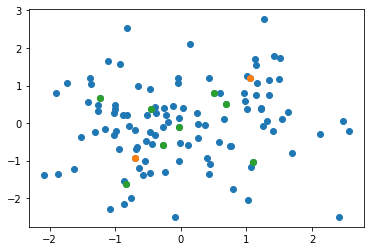

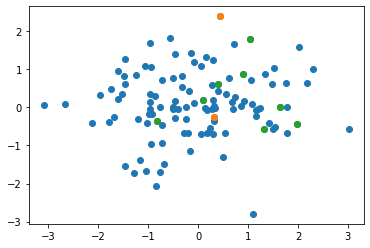

------------- Default ---------------------
------- set mode : hybrid -----------


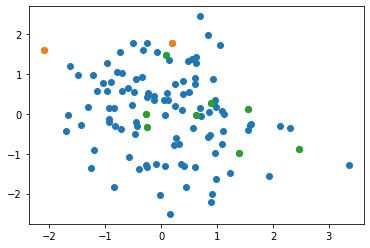

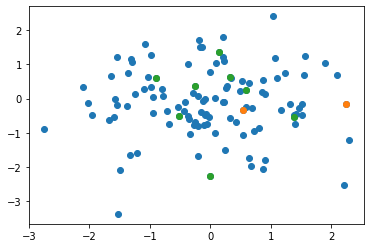

In [164]:
import matplotlib.pyplot as plt

print("----------- Learned ----------")
stock_ids = torch.tensor(dataset.main_df['stock_id'].unique())
# print(stock_ids)

embedding_predictor = model.hidden_generator_network.stock_id_embedding #.set_mode('stock_id_embedding')
pred = embedding_predictor({'stock_id':stock_ids})
datapoints = pred.tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([75,70])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([76,78,82,85,87,88,94,95])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
plt.show()


embedding_predictor = model.stock_id_embedding #.set_mode('stock_id_embedding')
pred = embedding_predictor({'stock_id':stock_ids})
datapoints = pred.tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([75,70])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([76,78,82,85,87,88,94,95])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
plt.show()

print("------------- Default ---------------------")
default_model = VolatilityBSModel().to(device)
embedding_predictor = default_model.hidden_generator_network.stock_id_embedding #.set_mode('stock_id_embedding')
pred = embedding_predictor({'stock_id':stock_ids})
datapoints = pred.tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([75,70])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([76,78,82,85,87,88,94,95])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
plt.show()


embedding_predictor = default_model.stock_id_embedding #.set_mode('stock_id_embedding')
pred = embedding_predictor({'stock_id':stock_ids})
datapoints = pred.tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([75,70])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
datapoints = embedding_predictor({'stock_id':torch.tensor([76,78,82,85,87,88,94,95])}).tolist()
plt.scatter([x[0] for x in datapoints], [x[1] for x in datapoints])
plt.show()

In [244]:
# torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIRECTORY,f"13_{STRATEGY_NAME_WITH_ATTRS}_epoch_{t}_tloss_{np.mean(losses_test):.4f}.pth"))
model_statedict = {'base':model.state_dict()}
for k,v in model.feature_gen_models.items():
    model_statedict[k] = v.state_dict()

torch.save(model_statedict, os.path.join(MODEL_OUTPUT_DIRECTORY,f"16_{STRATEGY_NAME_WITH_ATTRS}_epoch_{t}_tloss_{np.mean(losses_test):.4f}.pth"))

In [219]:
# model.state_dict()


    

23

In [65]:
def optiver_custom_collate_func(batch):
    output_x = {}
    for k,v in batch[0][0].items():
        output_x[k] = []
    
    for x_dict in [x[0] for x in batch]:
        for k,v in x_dict.items():
            output_x[k].append(v)
    
    for k,v in batch[0][0].items():
        if type(output_x[k][0]) != str:
            output_x[k] = torch.stack(output_x[k])
        
    output_y = []
    for y in [x[1] for x in batch]:
        output_y.append(y)
    output_y = torch.stack(output_y)
    
    return (output_x, output_y)
#     input()
#     print(batch)
# #     return batch
#     input()
#     return batch

In [249]:
stime = time.time()

    
dataloader_train = DataLoader(dataset, batch_size=1,
                                shuffle=True, num_workers=0, pin_memory=False)#, collate_fn=optiver_custom_collate_func)
# #             model.train()
# i = 0
# stockid = set()

def feature_transform(feature_x, feature_name):
        if feature_name in ['logrett_xs',
                             'logret1_xs','logret2_xs','book_bid_spread_xs','book_ask_spread_xs']:
            return feature_x * 10000
        if feature_name in ['book_price_spread1_xs','book_price_spread2_xs']:
            return feature_x * 1000
        if feature_name in ['trade_ordercount_xs','trade_volume_xs','trade_money_turnover_xs','trade_money_turnover_per_order_xs',
                             'book_total_volume_xs','book_volume_imbalance_xs','book_money_turnover1_xs']:
            return torch.log(feature_x + 1)
        return feature_x
    
for train_batch_idx, (Feature_X, feature_y) in enumerate(dataloader_train):
    i += 1
    for k,v in Feature_X.items():
        print(k)
        print(feature_transform(v,k))
        input()
    print(feature_y)
    input()
# batch = []
# for idx in range(len(dataset)):
#     batch.append(dataset[idx])
#     if idx % 128 == 0:
#         features_x = [x[0] for x in batch]
#         features_y = [x[1] for x in batch]
#         features_y = torch.tensor(features_y).reshape(-1,1)
# #         print(features_y)
# #         input()
#         batch = []
    
#     y = feature_y.to(device) * output_scaling 
#     print(Feature_X['logret1_xs'].type())
#     pred = model(Feature_X)
#     print(pred.type())
#     input()
#     for stk in Feature_X['row_id']:
        
#         stockid.add(stk.split("-")[0])
# for i in range(len(dataset)-10):
#     dataset[i]
print("-->", (time.time()-stime))

row_id
['96-13771']


stock_id
tensor([96.])


seconds_in_bucket_xs
tensor([[  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
          65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115., 120.,
         125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175., 180.,
         185., 190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240.,
         245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295., 300.,
         305., 310., 315., 320., 325., 330., 335., 340., 345., 350., 355., 360.,
         365., 370., 375., 380., 385., 390., 395., 400., 405., 410., 415., 420.,
         425., 430., 435., 440., 445., 450., 455., 460., 465., 470., 475., 480.,
         485., 490., 495., 500., 505., 510., 515., 520., 525., 530., 535., 540.,
         545., 550., 555., 560., 565., 570., 575., 580., 585., 590., 595., 600.]])


logrett_xs
tensor([[-0.2583, -0.2583, -0.2583, -0.2583, -0.2565, -0.2560, -0.2566, -1.2919,
         -0.0621, -0.0615, -0.0621, -0.0621, -0.2757, -0.2751,  2.5545, -0.3759,
          1.5375, -1.2732, -1.4517, -0.6660, -0.6666, -0.6661, -0.0943, -0.8810,
         -0.8745, -3.8643, -2.0211, -0.0137, -1.3876, -0.1028, -0.2772, -0.2766,
         -2.2825, -0.0269,  1.6510, -1.3265,  2.1354,  2.1350,  0.5107,  0.5112,
         -0.6612, -0.1995, -0.1995, -2.8131, -2.8139, -1.4733, -1.5446,  0.1518,
          1.3928, -0.8829, -0.2122, -0.2122, -0.4472, -0.4466, -0.4472,  1.6626,
          1.2654,  1.2647,  1.1127,  1.5446,  1.5443,  2.4143,  0.7716,  0.7715,
         -0.4849, -0.8379, -1.7267, -0.9193, -0.5514, -0.5508, -0.2246, -0.2252,
         -0.2252, -0.2247,  0.4583,  0.6620,  1.0186,  1.1863, -0.5597,  0.2849,
          0.2855,  0.2849, -0.0747, -0.8219, -0.8220, -0.0287, -0.0287, -0.0287,
          2.1707, -0.2222, -0.2222, -0.2222, -0.7705, -0.7706, -0.7707, -0.7707,
          0.2205,

trade_volume_xs
tensor([[5.3033, 0.0000, 0.0000, 5.3375, 0.0000, 0.0000, 5.3230, 5.2095, 0.0000,
         0.0000, 0.0000, 2.1972, 0.0000, 5.1417, 4.7875, 6.5191, 4.1431, 4.8203,
         4.6634, 0.0000, 0.0000, 6.4630, 3.0445, 2.8332, 6.4677, 4.8363, 4.5951,
         6.3648, 4.7958, 5.5175, 0.0000, 5.3566, 6.4568, 6.1203, 5.9081, 3.2581,
         0.0000, 6.5568, 0.0000, 0.6931, 2.1972, 0.0000, 4.6634, 0.0000, 5.7268,
         4.3175, 1.3863, 4.9836, 0.6931, 0.6931, 0.0000, 6.2916, 0.0000, 0.0000,
         4.6151, 6.0113, 0.0000, 0.6931, 5.3033, 0.0000, 6.1485, 4.6250, 0.0000,
         4.6151, 6.2226, 5.3230, 2.9444, 4.6151, 0.0000, 3.0445, 0.0000, 0.0000,
         0.0000, 5.7746, 3.6376, 0.6931, 6.0331, 1.6094, 5.2883, 0.0000, 0.0000,
         5.7170, 4.7274, 0.0000, 4.9558, 0.0000, 0.0000, 4.9345, 4.6250, 0.0000,
         0.0000, 5.3327, 0.0000, 0.0000, 0.0000, 1.0986, 0.6931, 0.0000, 1.0986,
         0.6931, 0.0000, 0.0000, 5.6312, 4.6250, 5.7557, 0.0000, 0.0000, 1.0986,
         5.7

trade_ordercount_xs
tensor([[1.9459, 0.0000, 0.0000, 2.1972, 0.0000, 0.0000, 1.7918, 2.0794, 0.0000,
         0.0000, 0.0000, 1.9459, 0.0000, 1.0986, 2.0794, 2.7081, 1.3863, 1.3863,
         1.3863, 0.0000, 0.0000, 2.1972, 0.6931, 1.0986, 2.0794, 1.0986, 1.3863,
         2.6391, 1.6094, 2.0794, 0.0000, 2.0794, 2.7081, 2.5649, 2.3979, 0.6931,
         0.0000, 2.6391, 0.0000, 0.6931, 1.3863, 0.0000, 1.0986, 0.0000, 2.0794,
         1.3863, 0.6931, 1.3863, 0.6931, 0.6931, 0.0000, 2.4849, 0.0000, 0.0000,
         1.0986, 2.5649, 0.0000, 0.6931, 1.3863, 0.0000, 2.9444, 1.0986, 0.0000,
         1.0986, 2.3979, 1.6094, 1.6094, 1.3863, 0.0000, 0.6931, 0.0000, 0.0000,
         0.0000, 2.3979, 1.0986, 0.6931, 2.7081, 0.6931, 1.9459, 0.0000, 0.0000,
         2.0794, 1.3863, 0.0000, 1.3863, 0.0000, 0.0000, 2.4849, 1.3863, 0.0000,
         0.0000, 1.7918, 0.0000, 0.0000, 0.0000, 1.0986, 0.6931, 0.0000, 1.0986,
         0.6931, 0.0000, 0.0000, 1.7918, 1.3863, 2.6391, 0.0000, 0.0000, 1.0986,
        

trade_money_turnover_xs
tensor([[5.3024, 0.0000, 0.0000, 5.3366, 0.0000, 0.0000, 5.3220, 5.2083, 0.0000,
         0.0000, 0.0000, 2.1962, 0.0000, 5.1404, 4.7865, 6.5181, 4.1423, 4.8193,
         4.6623, 0.0000, 0.0000, 6.4617, 3.0432, 2.8319, 6.4662, 4.8344, 4.5930,
         6.3626, 4.7936, 5.5152, 0.0000, 5.3543, 6.4542, 6.1178, 5.9057, 3.2557,
         0.0000, 6.5547, 0.0000, 0.6922, 2.1954, 0.0000, 4.6614, 0.0000, 5.7242,
         4.3147, 1.3841, 4.9807, 0.6917, 0.6917, 0.0000, 6.2886, 0.0000, 0.0000,
         4.6121, 6.0084, 0.0000, 0.6918, 5.3008, 0.0000, 6.1462, 4.6230, 0.0000,
         4.6133, 6.2206, 5.3210, 2.9424, 4.6129, 0.0000, 3.0423, 0.0000, 0.0000,
         0.0000, 5.7721, 3.6353, 0.6920, 6.0309, 1.6078, 5.2861, 0.0000, 0.0000,
         5.7150, 4.7253, 0.0000, 4.9536, 0.0000, 0.0000, 4.9322, 4.6229, 0.0000,
         0.0000, 5.3307, 0.0000, 0.0000, 0.0000, 1.0970, 0.6920, 0.0000, 1.0971,
         0.6921, 0.0000, 0.0000, 5.6288, 4.6224, 5.7532, 0.0000, 0.0000, 1.0969,
    

trade_money_turnover_per_order_xs
tensor([[3.5353, 0.0000, 0.0000, 3.2903, 0.0000, 0.0000, 3.7319, 3.7785, 0.0000,
         0.0000, 0.0000, 1.2229, 0.0000, 4.4531, 2.8894, 4.6450, 3.0749, 3.7367,
         3.9878, 0.0000, 0.0000, 5.2162, 3.0432, 2.1959, 4.5295, 4.8344, 4.5930,
         4.7957, 3.9296, 4.8843, 0.0000, 3.4363, 4.5166, 4.8029, 4.8006, 3.2557,
         0.0000, 5.0585, 0.0000, 0.6922, 1.2978, 0.0000, 3.9776, 0.0000, 3.7977,
         3.2425, 1.3841, 3.8957, 0.6917, 0.6917, 0.0000, 3.9091, 0.0000, 0.0000,
         3.9288, 3.5501, 0.0000, 0.6918, 5.0114, 0.0000, 3.2916, 3.9396, 0.0000,
         3.9300, 4.0547, 4.9082, 1.7030, 3.5339, 0.0000, 3.0423, 0.0000, 0.0000,
         0.0000, 4.3371, 2.9681, 0.6920, 4.2836, 1.6078, 3.5194, 0.0000, 0.0000,
         3.7886, 3.6443, 0.0000, 3.8690, 0.0000, 0.0000, 3.0954, 3.9492, 0.0000,
         0.0000, 4.0278, 0.0000, 0.0000, 0.0000, 0.6919, 0.6920, 0.0000, 0.6920,
         0.6921, 0.0000, 0.0000, 4.0336, 3.5432, 4.0198, 0.0000, 0.0000, 0.

logret1_xs
tensor([[-7.7680e-01, -7.7680e-01, -6.8623e-02,  6.7328e-01, -4.8532e-02,
          3.7172e-01,  5.6857e-02, -2.5074e-01, -9.9375e-01,  1.7405e-01,
          6.8433e-02,  7.0038e-01,  1.2492e-01, -1.3495e+00,  1.0666e+00,
          5.1070e-01, -4.1751e-02, -6.4015e-03, -6.7136e-01, -2.6296e-02,
          3.9817e-02, -9.8889e-01, -8.4128e-01, -1.1107e+00, -2.2903e+00,
         -1.5481e+00, -1.5099e+00, -9.2775e-01, -7.4993e-01, -1.3067e+00,
          1.8113e-01, -3.6812e-01, -2.8201e+00,  1.3158e-01,  1.6369e+00,
          1.9151e-01,  3.7371e-01,  1.7664e+00,  1.1575e+00, -1.1125e-01,
          7.9329e-02,  8.9109e-01, -3.4531e+00, -2.2108e+00, -1.5161e+00,
         -5.4590e-01, -7.1532e-01,  1.3627e-01, -5.4038e-01,  9.0180e-01,
         -7.0203e-01, -1.4106e+00, -1.5298e-01, -1.5299e-01, -1.0891e-03,
          2.9099e+00, -2.2905e-01, -4.5718e-01,  2.1538e+00,  1.5167e-01,
          4.0605e+00,  1.8936e-01,  5.3510e-01,  1.5238e+00,  4.5908e-01,
         -1.1990e+00, -7.94

logret2_xs
tensor([[ 0.9859,  0.9859, -0.1455, -1.2756,  1.5009, -0.0909, -0.0406, -0.5837,
         -0.5796, -0.9822,  0.3893,  0.4608, -0.0628, -0.1517,  0.0359,  0.9919,
         -0.5060,  0.0652, -1.9585, -0.5432,  0.4822, -0.3305, -0.2238,  0.0935,
         -2.9143, -2.2891, -1.2099, -1.0210, -2.9866,  0.9696,  0.1230, -1.1505,
         -1.7135,  0.2416,  1.8676, -0.2321,  0.1684,  1.8445, -0.0817, -1.3762,
          1.8866,  1.9385, -2.1587, -1.1067, -4.4063, -0.5619, -0.2444, -0.4791,
         -0.6453, -0.6869,  1.8901, -2.1611, -0.0178, -0.0178, -0.3498,  0.6256,
          0.5493,  2.6553,  1.5744, -0.6500,  2.3321,  2.1582,  1.2279,  0.2242,
         -0.4004, -0.2631, -2.0794, -0.5214,  0.0000,  1.0671, -0.2156, -0.0635,
         -0.0635, -3.0902,  1.6110,  0.0915, -0.6223,  1.2058, -0.1832,  0.1907,
         -0.1133,  1.5597,  0.1667, -1.8668, -0.6013, -0.3198,  1.0539, -1.2939,
          2.3039,  1.6961,  0.4793, -3.0270, -1.4520,  1.6252, -0.0483, -1.6339,
          0.6728,

book_directional_volume1_xs
tensor([[   4.2000,   70.0000,  106.3333,   34.7500,  245.0000,  212.0000,
          303.2000,  -21.7500,  -24.3333,  -51.5000,  -70.2000,  -80.0000,
         -127.0000,   -1.0000,   12.2500,   61.5000,   82.0000,   57.6667,
         -217.0000, -191.0000, -199.0000, -127.8000, -184.5000, -257.2500,
          -76.4000, -102.6000,  -63.4000,  -81.2500, -136.7500,   20.0000,
          -77.7500, -219.5000,  -30.7500,   14.0000,   -4.5000,  -96.0000,
           -4.0000,   64.7500,  -74.0000,  -94.6000,  -91.0000,  -99.0000,
          -40.0000,   97.0000,   81.7500, -100.0000, -100.6667, -118.3333,
          -33.0000,  -98.2500,  -50.0000, -121.7500,    0.0000,  -99.0000,
          -99.0000,  -98.6000, -152.5000,    0.0000,   35.6000,  148.5000,
          -74.5000,   76.7500,  157.0000, -159.2000, -155.4000,  -12.7500,
          -58.2000,  -11.0000, -111.0000,  -21.6000, -104.3333,    0.0000,
          -28.0000,  -46.2500,  -99.0000,  -98.5000,   26.7500,   -1.500

book_directional_volume2_xs
tensor([[  17.8000,  -99.0000,  -99.0000,   26.2500,  -41.7500,    0.0000,
           34.0000,    5.7500,  -95.6667,  -46.5000,  -89.8000,  -77.0000,
          -44.6000,  -24.0000,  -44.0000,   51.5000,   33.0000,  -10.6667,
           18.0000,   55.0000,   16.0000,   -8.0000, -165.7500, -162.7500,
          -50.6000,  -72.4000, -159.6000,  -76.2500,   56.2500,   -7.5000,
          -50.0000,   68.0000,  -71.2500,  -93.5000, -121.2500,  -68.4000,
          -77.0000,   23.5000,  -19.5000,   78.2000,   15.6000,  -78.0000,
         -126.6667, -101.0000,   50.5000,  -15.7500,  -48.3333,  -87.6667,
           57.6667,  244.5000, -154.0000,  -52.7500,    0.0000,  -99.0000,
          -59.0000,   61.6000,   38.0000, -100.0000,  -95.6000,   47.5000,
           37.2500,  101.2500,  -39.0000,  -51.2000,    1.8000,   13.2500,
           26.4000,    0.0000,    0.0000, -145.4000,  -91.3333,    0.0000,
          -95.0000,   14.2500,  -60.0000,  -59.5000,  113.5000,  -10.250

book_price_spread1_xs
tensor([[0.2467, 0.1835, 0.1762, 0.1817, 0.2643, 0.2423, 0.2291, 0.2313, 0.2644,
         0.2313, 0.2115, 0.2159, 0.1939, 0.2644, 0.1982, 0.2863, 0.1982, 0.1909,
         0.2129, 0.2203, 0.1982, 0.2379, 0.2754, 0.1598, 0.2645, 0.3086, 0.2337,
         0.1764, 0.2701, 0.2371, 0.1433, 0.1709, 0.2592, 0.1930, 0.2812, 0.4852,
         0.2315, 0.3583, 0.3032, 0.2161, 0.1852, 0.2095, 0.4852, 0.3639, 0.3033,
         0.2869, 0.2648, 0.2059, 0.1839, 0.1986, 0.1986, 0.2428, 0.2042, 0.1655,
         0.1765, 0.3839, 0.2923, 0.3089, 0.2912, 0.1985, 0.2426, 0.2150, 0.2425,
         0.2160, 0.2028, 0.2976, 0.1940, 0.3308, 0.3308, 0.2823, 0.2646, 0.2536,
         0.2426, 0.2812, 0.2647, 0.1765, 0.1599, 0.1102, 0.3583, 0.2646, 0.2316,
         0.2249, 0.4355, 0.3528, 0.3307, 0.3573, 0.2095, 0.2250, 0.2316, 0.3087,
         0.2205, 0.2602, 0.3307, 0.2867, 0.2867, 0.2206, 0.2206, 0.2867, 0.2867,
         0.3308, 0.2425, 0.2536, 0.2647, 0.2702, 0.2702, 0.2603, 0.0662, 0.0882,
      

book_price_spread2_xs
tensor([[0.3083, 0.2569, 0.2423, 0.2863, 0.4240, 0.4185, 0.3788, 0.3689, 0.3672,
         0.2864, 0.2732, 0.2908, 0.3172, 0.3084, 0.2808, 0.3359, 0.3480, 0.3230,
         0.3451, 0.3304, 0.3084, 0.3305, 0.3690, 0.3250, 0.3482, 0.3880, 0.2954,
         0.2977, 0.4190, 0.3749, 0.2977, 0.3088, 0.3584, 0.3253, 0.4631, 0.6175,
         0.4742, 0.5071, 0.4631, 0.4145, 0.4101, 0.3748, 0.6028, 0.5072, 0.4964,
         0.4523, 0.3751, 0.3163, 0.2795, 0.2538, 0.2647, 0.2979, 0.2704, 0.2428,
         0.2560, 0.4457, 0.4192, 0.4853, 0.5559, 0.3639, 0.3473, 0.3693, 0.4079,
         0.3439, 0.2998, 0.3858, 0.3704, 0.5292, 0.5292, 0.3837, 0.3528, 0.3418,
         0.3308, 0.5128, 0.3419, 0.2647, 0.2812, 0.3252, 0.5568, 0.3749, 0.2977,
         0.3043, 0.5181, 0.4410, 0.4576, 0.4367, 0.2702, 0.3484, 0.3969, 0.4355,
         0.3748, 0.4587, 0.4852, 0.3970, 0.3970, 0.3970, 0.3529, 0.3970, 0.3970,
         0.4631, 0.3749, 0.4301, 0.4853, 0.4026, 0.3971, 0.3618, 0.2868, 0.2941,
      

book_bid_spread_xs
tensor([[0.3964, 0.4404, 0.4404, 0.3303, 0.2752, 0.4404, 0.4404, 0.5507, 0.4405,
         0.3304, 0.3969, 0.5289, 0.7491, 0.2202, 0.3306, 0.2206, 1.0133, 1.1015,
         0.8815, 0.8815, 0.8815, 0.2203, 0.5510, 0.7161, 0.2203, 0.5292, 0.2204,
         0.2204, 1.1580, 0.9374, 0.4414, 0.7718, 0.2205, 0.2757, 1.0479, 0.6619,
         1.9852, 0.3310, 0.9923, 1.1028, 0.7498, 0.5510, 0.5145, 0.9926, 1.1034,
         0.9933, 0.8093, 0.5885, 0.4412, 0.3309, 0.4412, 0.2758, 0.4138, 0.5519,
         0.5742, 0.3976, 0.6624, 0.2206, 1.6769, 0.6618, 0.6062, 0.8820, 0.9924,
         0.6174, 0.5732, 0.6612, 1.2788, 0.2205, 0.2205, 0.3969, 0.6614, 0.6614,
         0.6614, 1.0478, 0.3308, 0.5512, 0.6614, 1.0477, 0.6066, 0.2205, 0.2205,
         0.5732, 0.6064, 0.6617, 0.7722, 0.4854, 0.2211, 0.6616, 0.8821, 0.6062,
         0.8823, 0.9704, 0.8824, 0.8824, 0.8824, 0.2205, 0.2205, 0.2205, 0.4416,
         0.6615, 0.6620, 0.7724, 0.8827, 0.7172, 0.8826, 0.2650, 1.5443, 1.5443,
         

book_ask_spread_xs
tensor([[0.2201, 0.2937, 0.2201, 0.7155, 1.3213, 1.3213, 1.0569, 0.8260, 0.5873,
         0.2202, 0.2202, 0.2202, 0.4847, 0.2202, 0.4958, 0.2752, 0.4844, 0.2203,
         0.4405, 0.2202, 0.2202, 0.7049, 0.3855, 0.9361, 0.6170, 0.2644, 0.3966,
         0.9920, 0.3306, 0.4410, 1.1027, 0.6063, 0.7722, 1.0477, 0.7716, 0.6612,
         0.4412, 1.1571, 0.6063, 0.8821, 1.4989, 1.1017, 0.6612, 0.4408, 0.8271,
         0.6616, 0.2944, 0.5150, 0.5150, 0.2211, 0.2205, 0.2757, 0.2482, 0.2206,
         0.2206, 0.2205, 0.6066, 1.5440, 0.9702, 0.9923, 0.4408, 0.6612, 0.6616,
         0.6614, 0.3967, 0.2205, 0.4848, 1.7637, 1.7637, 0.6173, 0.2204, 0.2204,
         0.2204, 1.2680, 0.4409, 0.3307, 0.5515, 1.1026, 1.3777, 0.8820, 0.4409,
         0.2204, 0.2203, 0.2204, 0.4960, 0.3088, 0.3857, 0.5732, 0.7713, 0.6611,
         0.6611, 1.0142, 0.6617, 0.2204, 0.2204, 1.5439, 1.1028, 0.8823, 0.6616,
         0.6618, 0.6618, 0.9925, 1.3233, 0.6068, 0.3860, 0.7503, 0.6621, 0.5149,
         

book_total_volume_xs
tensor([[7.0309, 6.2653, 6.4536, 6.9670, 7.5380, 6.1377, 7.9356, 6.8617, 5.9738,
         6.4877, 6.7581, 6.9295, 7.1538, 4.0775, 6.9866, 8.0020, 8.0449, 7.4685,
         6.9315, 6.6958, 6.8459, 7.1808, 7.6401, 7.7558, 6.8200, 6.8896, 7.6658,
         6.9575, 7.2086, 7.2800, 7.4512, 7.1982, 7.6113, 7.3402, 7.2034, 7.4343,
         5.5568, 7.4372, 6.7811, 7.0379, 7.0527, 6.1026, 6.8512, 6.1841, 6.9866,
         6.2577, 6.9660, 6.9949, 7.1025, 7.5486, 6.0426, 7.0148, 0.0000, 6.0039,
         7.0992, 7.2485, 7.2086, 6.2166, 7.6192, 6.4877, 7.1808, 7.4691, 6.8035,
         7.3746, 7.6540, 6.5028, 6.6412, 4.0943, 5.0752, 6.9508, 6.5073, 0.0000,
         6.3333, 6.6053, 5.7900, 5.8021, 7.5262, 6.8669, 7.0344, 6.6067, 6.8565,
         7.4110, 7.0344, 6.7811, 7.0493, 6.3491, 5.3423, 7.0951, 6.8669, 6.8835,
         5.7961, 6.9037, 5.4337, 5.4765, 5.4806, 4.7958, 4.6151, 3.9512, 5.4510,
         6.1985, 5.7071, 0.0000, 6.1026, 7.0758, 6.1985, 5.6937, 4.7095, 3.5553,
       

book_volume_imbalance_xs
tensor([[4.6653, 3.4012, 2.1203, 4.1271, 5.3193, 5.3613, 5.8236, 5.0783, 4.7958,
         4.5951, 5.0814, 5.0626, 5.1510, 3.2581, 3.8011, 4.9090, 5.0999, 4.1795,
         5.2983, 4.9200, 5.2149, 4.9185, 5.8615, 6.0426, 4.8520, 5.1705, 5.4116,
         5.2730, 4.4886, 4.6492, 4.8579, 5.1090, 4.6347, 5.0073, 4.8422, 5.1084,
         4.4067, 4.9541, 4.5747, 2.8565, 4.3360, 5.1818, 5.1259, 4.6052, 4.8922,
         4.7600, 5.0106, 5.3327, 4.7391, 4.9921, 5.3230, 5.1676, 0.0000, 5.2933,
         5.0739, 3.6376, 4.7493, 4.6151, 4.9459, 5.2832, 4.0818, 5.1874, 4.7791,
         5.3538, 5.0408, 3.8607, 4.2370, 2.4849, 4.7185, 5.1240, 5.2815, 0.0000,
         4.8203, 3.9120, 5.0752, 5.0689, 4.9505, 3.3759, 4.8363, 4.4514, 4.8847,
         4.7005, 3.4177, 4.1217, 4.5191, 4.1141, 3.5115, 4.8828, 4.9955, 5.1075,
         4.3944, 4.7808, 5.1985, 1.6094, 1.7918, 2.4849, 3.1781, 3.8286, 4.7185,
         5.3107, 5.5491, 0.0000, 5.8777, 5.1417, 3.4095, 3.8330, 3.9512, 2.1203,
   

book_money_turnover1_xs
tensor([[2.1963, 1.9449, 1.9449, 4.6624, 5.5824, 4.6141, 5.3171, 2.3016, 1.3854,
         4.3808, 1.7908, 1.7909, 1.7909, 1.0978, 3.3663, 5.7858, 4.6624, 4.6434,
         4.1261, 4.1421, 1.3855, 2.0784, 5.3458, 5.7607, 4.7690, 1.9444, 4.6520,
         1.7901, 5.4909, 6.0569, 1.6077, 1.7899, 6.0472, 5.3156, 5.1156, 5.2235,
         1.0971, 5.5032, 4.6423, 3.3303, 3.8267, 1.0973, 4.6323, 3.2165, 5.1621,
         1.6073, 5.3153, 1.3842, 1.3842, 1.7895, 1.0968, 4.6414, 0.0000, 1.0967,
         1.7893, 4.7069, 5.3105, 4.6124, 5.4137, 4.6610, 5.9969, 4.7938, 5.3499,
         1.7902, 3.2942, 4.9180, 1.7901, 0.6921, 0.6921, 2.3006, 2.7706, 0.0000,
         4.8419, 1.6076, 1.0971, 1.3846, 5.9917, 5.9767, 5.1337, 4.5304, 4.5304,
         5.6038, 6.0190, 4.6519, 1.6079, 1.9440, 3.5532, 1.9439, 4.8421, 4.5725,
         4.6131, 2.3960, 0.6920, 4.5517, 4.5517, 1.3844, 1.0970, 1.0971, 1.3846,
         1.0972, 0.6921, 0.0000, 3.0888, 5.4091, 4.2879, 1.7895, 1.0969, 1.3844,
    

tensor([[0.0023]])


row_id
['9-633']


stock_id
tensor([9.])


seconds_in_bucket_xs
tensor([[  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
          65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115., 120.,
         125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175., 180.,
         185., 190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240.,
         245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295., 300.,
         305., 310., 315., 320., 325., 330., 335., 340., 345., 350., 355., 360.,
         365., 370., 375., 380., 385., 390., 395., 400., 405., 410., 415., 420.,
         425., 430., 435., 440., 445., 450., 455., 460., 465., 470., 475., 480.,
         485., 490., 495., 500., 505., 510., 515., 520., 525., 530., 535., 540.,
         545., 550., 555., 560., 565., 570., 575., 580., 585., 590., 595., 600.]])


KeyboardInterrupt: Interrupted by user

In [ ]:
torch.cuda.close()

In [ ]:
torch.cuda.memory_allocated(device)/1024/1024/1024
# model.to("cpu")
# torch.cuda.memory_stats()

In [ ]:
torch.cuda.init()